**Table of contents**<a id='toc0_'></a>    
- [Data Preprocessing](#toc1_1_)    
- [OPTIONAL: Keras tuner to get optimal layer and neuron](#toc2_)    
- [ML Modelling](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data Preprocessing](#toc0_)

In [1]:
import pandas as pd
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('clean_data.csv')

X = data[['left_shoulder_y', 'left_shoulder_x', 'right_shoulder_y', 'right_shoulder_x', 'left_body_y', 'left_body_x', 'right_body_y', 'right_body_x', 'len_factor', 'left_knee_y', 'left_knee_x', 'right_knee_y', 'right_knee_x', 'left_foot_y', 'right_foot_y']]
y = data['fall'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Generated {len(X_train)} training samples and {len(X_test)} testing samples")

# Standardize the features - IMPORTANT
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-11-01 04:15:10.941564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730409310.953539  138417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730409310.956994  138417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 04:15:10.969613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generated 109 training samples and 28 testing samples


# <a id='toc2_'></a>[OPTIONAL: Keras tuner to get optimal layer and neuron](#toc0_)

In [ ]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Dropout
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=16, max_value=40, step=8),
                        activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.3))
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=8, max_value=32, step=8),
                            activation='relu'))
            model.add(Dropout(0.2))
        
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])
        return model

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,
    directory='keras_tuner',
    project_name='fall_detection'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[reduce_lr])
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
best_model.summary()

Best Model
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

# <a id='toc3_'></a>[ML Modelling](#toc0_)

In [ ]:
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Dense, Dropout, Input
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras._tf_keras.keras.metrics import AUC
import tensorflow as tf

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(24, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=BinaryCrossentropy(), 
    metrics=['accuracy', AUC(name='auc')])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, restore_best_weights=True, verbose=1)
model.summary()

In [ ]:
history = model.fit(
    X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stop]
)
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

In [7]:
model.save('fall_detection_model.keras')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


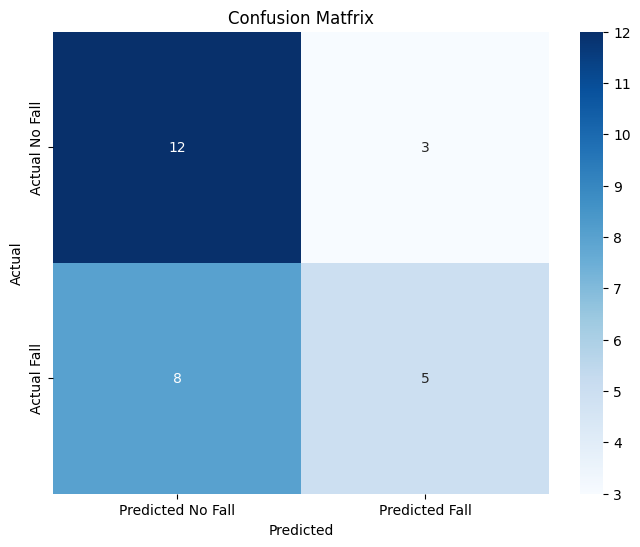

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
model = tf.keras.models.load_model('fall_detection_model.keras')
# Test model
THRESHOLD = 0.6
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >= THRESHOLD, 1, 0)


# Compute and visualizethe confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Fall', 'Predicted Fall'], yticklabels=['Actual No Fall', 'Actual Fall'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matfrix')
plt.show()